#  Angular velocity curves.

In this notebook we review the angular velocity curves of the four experiments realized on 18th of June 2018. The processing of these experiments is stored in the [Processing](https://nbviewer.jupyter.org/github/aortiza/Notes/tree/master/Microrheometer/Depinning/) notebooks, and it results in the creation of one *hdf5* file for each loop, which contains two fields: `trj` and `omegas`.
* The `trj` field contains the trajectories of all the particles in micrometers, and also the value of the field at the moment the frame was taken. 
* The `omegas` field contains the value of the angular velocity as a function of field.

In [1]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
import h5py

import support as sp

from tqdm import tqdm_notebook

%matplotlib inline

idx = pd.IndexSlice

### get names

We first grab a list of all the existent files in the experiment folder.

In [3]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment5/ProcessedData/"
base_names = sp.get_names(directory,ext='.hd5')

### read angular velocity
We define a function that reads the angular velocity of a file, and then we iterate it over the list of existent files. This last iteration is stored on a list, which is then converted into a large pandas array with a condensate of all the lists. That way we can use the `groupby` method for pandas dataframes.

In [7]:
def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
    
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

A Jupyter Widget

In [103]:
with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    hdf_results.put('Experiment5/omegas',results,format = 't')

### what is the duration of the loop?

In [43]:
def total_time(trj):
    time = trj.index.get_level_values("time")
    return time[-1]-time[0]

In [44]:
%%time
def load_trj(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        trj = hdf_trj.select('trj')
        time = total_time(trj)
        return trj, time
    
trj, time = load_trj(base_names[0])

Wall time: 1min 45s


In [69]:
time

Timedelta('0 days 00:19:59.968000')

This means that the forward part of the loop takes 20 minutes. That means we do 60 steps of 20 seconds each step to go from $B_0^2 = 0mT^2$ to $B_0^2=0.3mT^2$. The total time to make a loop will then be 40 minutes

For now, we will store the time as 40 minutes, but later we should calculate the actual mean time, as well as the radius. A good idea might be to put all of the experiments in a single hdf5 file.

In [133]:
with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    hdf_results.get_node('Experiment5')._v_attrs.loop_time = pd.Timedelta('40 min')

### How many sweeps are we doing?

In [156]:
f = lambda x: len(x.experiment.unique())

sweeps = results.groupby('direction').apply(f)
sweeps["total"] = sum(sweeps)
sweeps

direction
backward    17
forward     17
total       34
dtype: int64

In [157]:
with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    sweeps = results.groupby('direction').apply(f)
    sweeps["total"] = sum(sweeps)
    sweeps
    hdf_results.get_node('Experiment5')._v_attrs.sweep_count = sweeps

## Repeat for all other experiments

In [158]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment4/ProcessedData/"
base_names = sp.get_names(directory,ext='.hd5')

def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
    
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    hdf_results.put('Experiment4/omegas',results,format = 't')
    hdf_results.get_node('Experiment4')._v_attrs.loop_time = pd.Timedelta('20 min')
    sweeps = results.groupby('direction').apply(f)
    sweeps["total"] = sum(sweeps)
    sweeps
    hdf_results.get_node('Experiment4')._v_attrs.sweep_count = sweeps

A Jupyter Widget

In [159]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment3/ProcessedData/"
base_names = sp.get_names(directory,ext='.hd5')

def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
    
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    hdf_results.put('Experiment3/omegas',results,format = 't')
    hdf_results.get_node('Experiment3')._v_attrs.loop_time = pd.Timedelta('10 min')
    sweeps = results.groupby('direction').apply(f)
    sweeps["total"] = sum(sweeps)
    sweeps
    hdf_results.get_node('Experiment3')._v_attrs.sweep_count = sweeps    

A Jupyter Widget

In [161]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment2/ProcessedData/"
base_names = sp.get_names(directory,ext='.hd5')

def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
    
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    hdf_results.put('Experiment2/omegas',results,format = 't')
    hdf_results.get_node('Experiment2')._v_attrs.loop_time = pd.Timedelta('2 min')
    sweeps = results.groupby('direction').apply(f)
    sweeps["total"] = sum(sweeps)
    sweeps
    hdf_results.get_node('Experiment2')._v_attrs.sweep_count = sweeps

A Jupyter Widget

# Load data and plot:

In [214]:
def plot_omegas(omegas):
    omegas_stat = omegas.groupby(["direction","field","layer"]).mean().filter(["omega"])
    omegas_stat['error'] = omegas.groupby(["direction","field","layer"]).std().filter(["omega"])/\
                                np.sqrt(omegas.groupby(["direction","field","layer"]).count().filter(["omega"]))
    omegas_stat.head()

    colors = [[0,0,0],[0.7,0,0],[0,0.7,0],[0,0,0.7]]

    for i in np.arange(4):

        plt.errorbar(
            (omegas_stat.loc[sp.idx["forward",:,i],:].index.get_level_values("field")*1.5)**2,
            -omegas_stat.loc[sp.idx["forward",:,i],:].omega,
            omegas_stat.loc[sp.idx["forward",:,i],:].error,
            color=colors[i])
        plt.errorbar(
            (omegas_stat.loc[sp.idx["backward",:,i],:].index.get_level_values("field")*1.5)**2,
            -omegas_stat.loc[sp.idx["backward",:,i],:].omega,
            omegas_stat.loc[sp.idx["backward",:,i],:].error,
            color=colors[i],alpha=0.5)

    font_size = 17
    plt.rc('text', usetex=True)
    plt.rc('font', size=font_size)

    plt.ylabel(r"$\omega\ [\textrm{rad}\ s^{-1}]$",fontsize=font_size)
    plt.xlabel(r"$\left(B_0\ [mT]\right)^2$",fontsize=font_size)

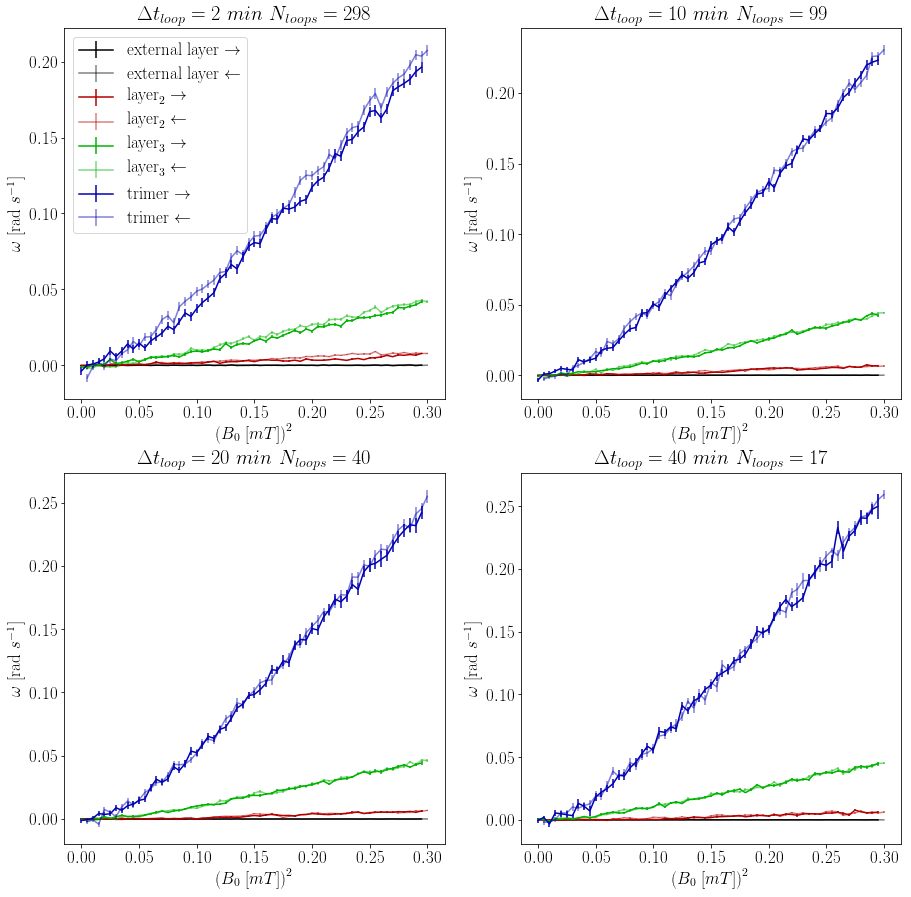

In [251]:
fig, ax = plt.subplots(2,2,figsize=[15,15])
with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    plt.sca(ax[0,0])
    plot_omegas(hdf_results.select('Experiment2/omegas'))
    
    plt.legend((
    r'$\textrm{external layer} \rightarrow$',
    r'$\textrm{external layer} \leftarrow$',
    r'$\textrm{layer}_2 \rightarrow$',
    r'$\textrm{layer}_2 \leftarrow$',
    r'$\textrm{layer}_3 \rightarrow$',
    r'$\textrm{layer}_3 \leftarrow$',
    r'$\textrm{trimer} \rightarrow$',
    r'$\textrm{trimer} \leftarrow$'),fontsize=font_size)
    
    def title(experiment):
        time = float(hdf_results.get_node(experiment)._v_attrs.loop_time.seconds)/60
        loops = hdf_results.get_node(experiment)._v_attrs.sweep_count.total
        return r'$\Delta{}t_{loop} = %u\ min$ $N_{loops} = %u$'%(time,np.floor(loops/2))
    
    plt.title(title("Experiment2"))
    
    plt.sca(ax[0,1])
    plot_omegas(hdf_results.select('Experiment3/omegas'))
    plt.title(title("Experiment3"))

    plt.sca(ax[1,0])
    plot_omegas(hdf_results.select('Experiment4/omegas'))
    plt.title(title("Experiment4"))

    plt.sca(ax[1,1])
    plot_omegas(hdf_results.select('Experiment5/omegas'))
    plt.title(title("Experiment5"))

# Angular velocity vs field of a single sweep. 


In [249]:
with pd.HDFStore('2018-06-18-Data_Condensed.hd5') as hdf_results:
    omegas = hdf_results.select('Experiment4/omegas')

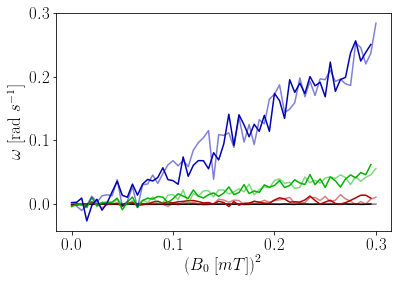

In [250]:
plot_omegas(omegas[(omegas.experiment==0) | (omegas.experiment==1)])